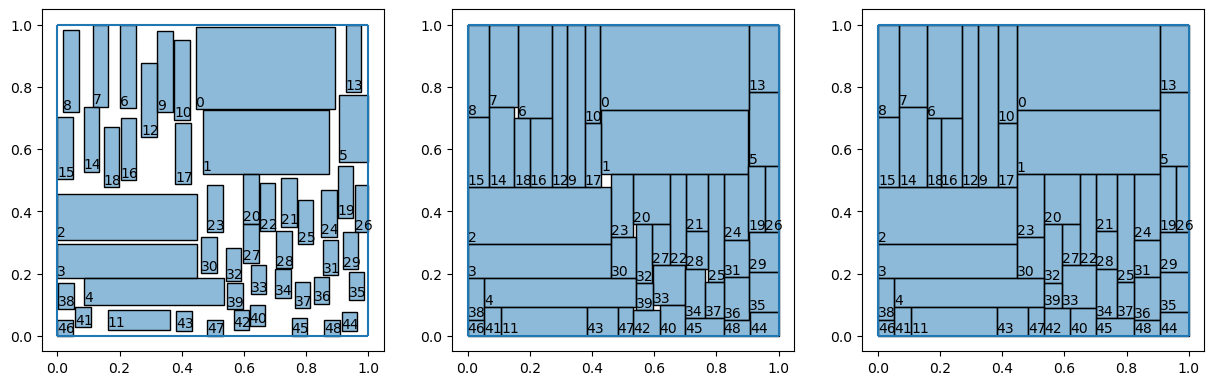

In [3]:
import numpy as np
from SquareDivision.src.rectangle_class import Rectangulation

rects = Rectangulation(config={'seed' : 12356005403})
rects.execute(num=800)
rects.prepare_constraints()
rects.close_holes()

rects.draw(disjoint=True, inflated=True, closed=True)

In [2]:
rects.report(tol=0.015)

rectangle no. 27 relatively changed by  0.099 
rectangle no. 12 relatively changed by  0.072 
rectangle no. 31 relatively changed by  0.058 
rectangle no.  2 relatively changed by  0.055 
rectangle no. 20 relatively changed by  0.053 
rectangle no. 23 relatively changed by  0.050 
rectangle no. 11 relatively changed by  0.048 
rectangle no. 14 relatively changed by  0.048 
rectangle no.  3 relatively changed by  0.048 
rectangle no. 25 relatively changed by  0.036 
rectangle no. 28 relatively changed by  0.036 
rectangle no. 19 relatively changed by  0.034 
rectangle no. 21 relatively changed by  0.033 
rectangle no.  4 relatively changed by  0.031 
rectangle no. 47 relatively changed by  0.031 
rectangle no. 30 relatively changed by  0.029 
rectangle no. 42 relatively changed by  0.027 
rectangle no.  0 relatively changed by  0.024 
rectangle no. 13 relatively changed by  0.021 
rectangle no. 38 relatively changed by  0.021 
rectangle no. 43 relatively changed by  0.021 
rectangle no.

In [39]:
rects.build_rectangles(num=5)
rects.rectangles

array([[0.89337486, 0.12569057, 0.27334371, 0.08142264],
       [0.26732109, 0.2684583 , 0.11683027, 0.11711458],
       [0.42153006, 0.15973078, 0.15538251, 0.0899327 ],
       [0.43748076, 0.01969308, 0.15937019, 0.05492327],
       [0.84381303, 0.62923292, 0.26095326, 0.20730823]])

In [43]:
rects.rectangles

array([[0.89337486, 0.12569057, 0.27334371, 0.08142264],
       [0.26732109, 0.2684583 , 0.11683027, 0.11711458],
       [0.42153006, 0.15973078, 0.15538251, 0.0899327 ],
       [0.43748076, 0.01969308, 0.15937019, 0.05492327],
       [0.84381303, 0.62923292, 0.26095326, 0.20730823]])

In [44]:
adotat = np.linalg.inv(np.matmul(rects.constraint.A, np.transpose(rects.constraint.A)))
l = np.matmul(adotat, -rects.constraint.A.dot(rects.x0)+rects.constraint.lb)

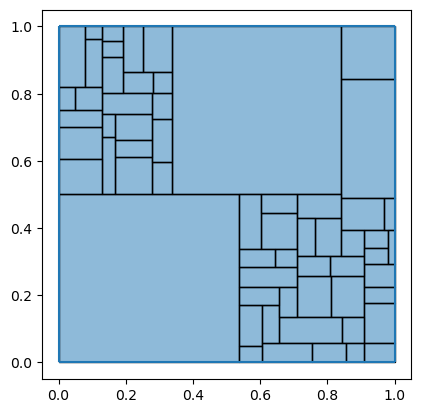

In [50]:
import matplotlib.pyplot as plt
from SquareDivision.draw.draw import draw_rectangles, rectangle_numbers
lin_sol = (rects.x0 + (rects.constraint.A.T).dot(l)).reshape(-1,4)
fig, ax = plt.subplots()
ax = draw_rectangles(ax, lin_sol)

In [46]:
import numpy as np
from SquareDivision.src.distributions import RngDistribution, SizeDistribution, linear_on_position
rects.sample_centers(RngDistribution(), rng=rects.rng, distribution='uniform', low=[0, 0], high=[1, 1], size=(5, 2))
rects.sample_widths(
    startegy=SizeDistribution(), 
    centers=rects.centers, 
    size_distribution=lambda arg : linear_on_position(arg, a=np.array([0.25, 0.0]), b=0.05))
rects.sample_heights(
    startegy=SizeDistribution(), 
    centers=rects.centers,
    size_distribution=lambda arg : linear_on_position(arg, a=np.array([0.0, 0.25]), b=0.05))

In [47]:
arr = np.c_[rects.centers, rects.widths, rects.heights]
print(arr)
print(f'centers:\n{rects.centers}')
print(f'widths:\n{rects.widths}')
print(f'heights:\n{rects.heights}')

[[0.40891237 0.02703582 0.15222809 0.05675896]
 [0.55605341 0.44201073 0.18901335 0.16050268]
 [0.30774572 0.6887314  0.12693643 0.22218285]
 [0.50895497 0.13692818 0.17723874 0.08423205]
 [0.94315182 0.98129848 0.28578795 0.29532462]]
centers:
[[0.40891237 0.02703582]
 [0.55605341 0.44201073]
 [0.30774572 0.6887314 ]
 [0.50895497 0.13692818]
 [0.94315182 0.98129848]]
widths:
[0.15222809 0.18901335 0.12693643 0.17723874 0.28578795]
heights:
[0.05675896 0.16050268 0.22218285 0.08423205 0.29532462]


In [4]:
from SquareDivision.src.distributions import tepui_distribution
print(rects.centers)
tepui_distribution(rects.centers, pts=np.array(
            [[0.25, 0.25],
             [0.75, 0.75],]
             )
    )

[[0.73892551 0.64887878]
 [0.38057859 0.0023377 ]
 [0.58649654 0.75154463]]


array([0.3 , 0.05, 0.3 ])

In [5]:
rects.sample_heights(
    startegy=SizeDistribution(), 
    centers=rects.centers,
    size_distribution=tepui_distribution)

In [6]:
print(f'heights:\n{rects.heights}')

heights:
[0.3  0.05 0.3 ]


#### Maybe x0 from the graph ?

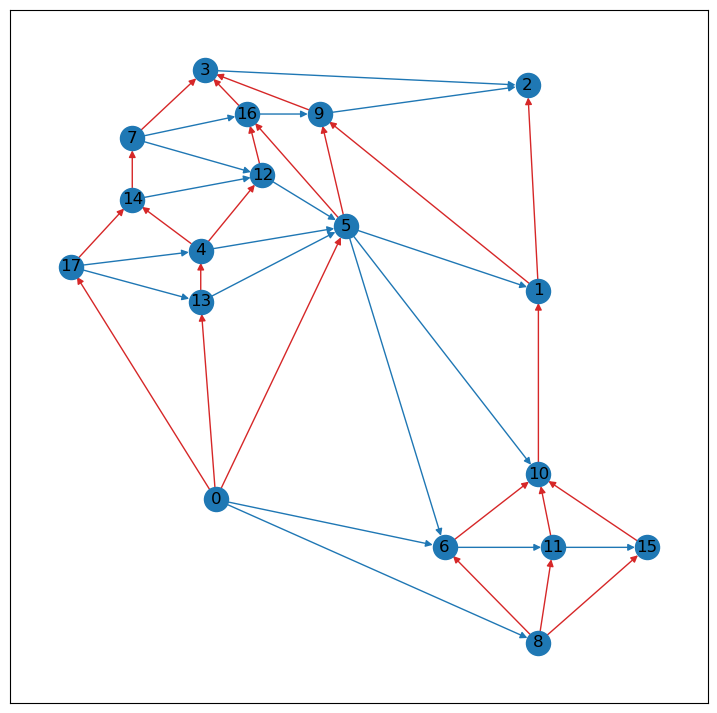

In [3]:
rects.graph_processing(rects.closed)
import networkx as nx
import matplotlib.pyplot as plt
H = nx.from_numpy_array(rects.east_neighbours, create_using=nx.DiGraph)# + rects.north_neighbours)
V = nx.from_numpy_array(rects.north_neighbours, create_using=nx.DiGraph)# + rects.north_neighbours)
attrs = { i : {'pos': tuple(row[:2] + 0.5 * row[2:4])} for i, row in enumerate(rects.clinched_rectangles)}
nx.set_node_attributes(H, attrs)
pos = nx.get_node_attributes(H,'pos')
fig, ax = plt.subplots(figsize=(9, 9))
nx.draw_networkx(H, pos=pos, ax=ax,  edge_color='tab:blue' )
nx.draw_networkx_edges(V, pos=pos, ax=ax, edge_color='tab:red')
plt.show()

In [73]:
import numpy as np
a = np.arange(80)
a = a.reshape(-1,4)
a[[5,3,7,0]] = np.arange(16).reshape(-1,4)


array([[12, 13, 14, 15],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [ 4,  5,  6,  7],
       [16, 17, 18, 19],
       [ 0,  1,  2,  3],
       [24, 25, 26, 27],
       [ 8,  9, 10, 11],
       [32, 33, 34, 35],
       [36, 37, 38, 39],
       [40, 41, 42, 43],
       [44, 45, 46, 47],
       [48, 49, 50, 51],
       [52, 53, 54, 55],
       [56, 57, 58, 59],
       [60, 61, 62, 63],
       [64, 65, 66, 67],
       [68, 69, 70, 71],
       [72, 73, 74, 75],
       [76, 77, 78, 79]])

In [11]:
rhs_test= (
    [ 
        [0,1,2],
        'bidon',
        'mniam',
        (2,'43'),
        ['fr'],
        ['oo',32],
    ] 
    + [0,['foo','bar']]
)
rhs_test

[[0, 1, 2], 'bidon', 'mniam', (2, '43'), ['fr'], ['oo', 32], 0, ['foo', 'bar']]

#### (w,h) Distribution playground

In [3]:
import numpy as np
pts_diag = np.array(
                 [[0.25, 0.25],
                  [0.75, 0.75]])
def tepui(
        base:float=0.05,
        top:float=0.3,
        slope:float=4,
        vertex:float=1,
        pts:np.ndarray=pts_diag
):
    return lambda pt : np.minimum(top, np.maximum(base, vertex - slope * np.min(np.linalg.norm(pts - pt, axis=1))))

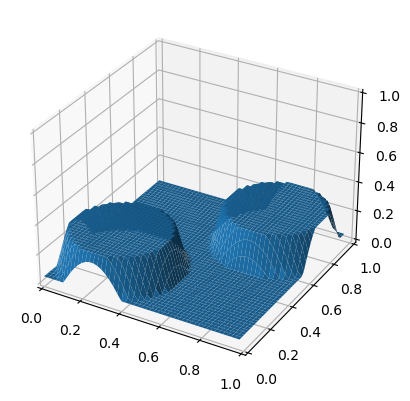

In [6]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

tepui_at = tepui(
        base=0.05,
        top=0.3,
        slope=5,
        vertex=1.5,
)

x = np.arange(0, 1, 0.02)
y = np.arange(0, 1, 0.02)

X, Y = np.meshgrid(x, y)
points = np.array([X,Y])

nu = np.apply_along_axis(tepui_at, 0, points)

fig = plt.figure()
ax:Axes = fig.add_subplot(projection='3d')
ax.axes.set_xlim3d(left=0, right=1) 
ax.axes.set_ylim3d(bottom=0, top=1) 
ax.axes.set_zlim3d(bottom=0, top=1) 
ax.plot_surface(X, Y, nu)
plt.show()

In [10]:
import numpy as np
x = np.arange(16).reshape(-1,4)
shape = x.shape
# y = np.ones(shape=(4,4))
# np.linalg.norm(x-y )
np.ravel_multi_index(multi_index=([0,2],[2,3],[2,0]), dims=shape) 

ValueError: parameter multi_index must be a sequence of length 2

In [2]:
import numpy as np
np.where(np.sum(rects.east_neighbours, axis=1) == 0)[0]
# for rect_num in range(shape[0]):
#         if np.sum(upper_neighbours.T[rect_num]) == 0:

array([ 1,  2,  8, 10, 15], dtype=int64)

In [9]:
import numpy as np
from numpy.random._generator import Generator

def call_experiment(distribution, rng:Generator, **kwargs):
    return rng.__getattribute__(distribution)(**kwargs)
xmin, ymin, xmax, ymax = 0, 0, 1, 1
# [xmin, ymin], [xmax, ymax], size=(2, 2)
call_experiment('uniform', rects.rng, low=[0, 0], high=[1, 1], size=(2, 2))

array([[0.95186745, 0.26756241],
       [0.69207914, 0.72522422]])